# Model Evaluation Comparison Dashboard

## CIM Wizard Text-to-SQL Model Performance Analysis

This notebook provides comprehensive visualizations to compare fine-tuned local LLMs against frontier API models.

### Models: SQLCoder 7B, Qwen 14B, GPT-4o-mini, GPT-4o-turbo, Claude Sonnet

### Metrics: EX, EA, Deep EM, SC

### Taxonomy: Task/Domain Type/Complexity/Frequency, Question Tone (5 values), Sample Dirtiness (3 values)

In [2]:
# Core imports
import json, glob
from pathlib import Path
from typing import Dict, List, Any, Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Color schemes
COLORS = {'local': '#2ecc71', 'frontier': '#3498db', 'ex': '#e74c3c', 'ea': '#2ecc71', 'deep_em': '#f39c12', 'sc': '#9b59b6'}
TONE_COLORS = {'INTERROGATIVE': '#3498db', 'DIRECT': '#2ecc71', 'DESCRIPTIVE': '#f39c12', 'AMBIGUOUS': '#e74c3c', 'OUT_OF_SCOPE': '#95a5a6'}
DIRTINESS_COLORS = {'CLEAN': '#2ecc71', 'AMBIGUOUS': '#f39c12', 'OUT_OF_SCOPE': '#e74c3c'}

print('Libraries loaded!')

Libraries loaded!


## 1. Load Evaluation Results

In [3]:
@dataclass
class ModelResult:
    name: str
    display_name: str
    model_type: str  # 'local' or 'frontier'
    parameters: Optional[str]
    data: Dict[str, Any]
    
    @property
    def overall(self): return self.data.get('overall', {})
    @property
    def taxonomy(self): return self.data.get('taxonomy_metrics', {})
    
    def get_metric(self, metric):
        m = {'ex': 'ex_accuracy', 'ea': 'ea_accuracy', 'deep_em': 'deep_em_accuracy', 'sc': 'semantic_correctness'}
        return self.overall.get(m.get(metric, metric), 0.0)


def load_single_result(filepath: str, display_name: str, model_type: str, parameters: Optional[str] = None):
    """Load a single result file with explicit model information."""
    try:
        filepath = Path(filepath)
        if not filepath.exists():
            print(f"Warning: File not found: {filepath}")
            return None
        
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        model_spec = data.get('model', filepath.stem)
        result = ModelResult(model_spec, display_name, model_type, parameters, data)
        print(f'Loaded: {display_name} ({model_type}) from {filepath.name}')
        return result
    except Exception as e:
        print(f'Error loading {filepath}: {e}')
        return None


def load_results_auto(results_dir='.'):
    """Auto-load all ea_v2_results_*.json files (fallback method)."""
    results = []
    model_info = {
        'sqlcoder': ('SQLCoder 7B', 'local', '7B'),
        'qwen': ('Qwen 14B', 'local', '14B'),
        'gpt-4o-mini': ('GPT-4o Mini', 'frontier', None),
        'gpt-4o': ('GPT-4o Turbo', 'frontier', None),
        'gpt4o': ('GPT-4o Turbo', 'frontier', None),
        'claude': ('Claude Sonnet', 'frontier', None),
        'sonnet': ('Claude Sonnet', 'frontier', None),
        'sonnet35': ('Claude Sonnet 3.5', 'frontier', None),
    }
    
    patterns = ['ea_v2_results_*.json', '*results*.json', '*.json']
    for pattern in patterns:
        for filepath in glob.glob(str(Path(results_dir) / pattern)):
            try:
                with open(filepath, 'r') as f:
                    data = json.load(f)
                model_spec = data.get('model', Path(filepath).stem)
                display_name, model_type, params = model_spec, 'frontier', None
                for key, (name, mtype, p) in model_info.items():
                    if key.lower() in model_spec.lower() or key.lower() in Path(filepath).stem.lower():
                        display_name, model_type, params = name, mtype, p
                        break
                results.append(ModelResult(model_spec, display_name, model_type, params, data))
                print(f'Auto-loaded: {display_name} ({model_type}) from {Path(filepath).name}')
            except Exception as e:
                continue  # Skip non-JSON or invalid files
    return results


# ============================================================================
# MANUAL LOADING - Modify this section to load your specific result files
# ============================================================================

results = []

# Option 1: Manual loading with explicit paths and model info
# Update the paths below to match your actual result files

MANUAL_RESULTS = [
    ('results/sqlcoder_results_20251126_1230.json', 'SQLCoder 7B (Fine-tuned)', 'local', '7B'),
    ('results/ea_v2_results_gpt4omini_20251126_1414.json', 'GPT-4o Mini (Fine-tuned)', 'local', None),
    # Format: (filepath, display_name, model_type, parameters)
    # Example entries - UPDATE THESE:
    # ('results/sqlcoder_results.json', 'SQLCoder 7B (Fine-tuned)', 'local', '7B'),
    # ('results/qwen_results.json', 'Qwen 14B (Fine-tuned)', 'local', '14B'),
    # ('results/gpt4o_mini_results.json', 'GPT-4o Mini', 'frontier', None),
    # ('results/gpt4o_turbo_results.json', 'GPT-4o Turbo', 'frontier', None),
    # ('results/claude_sonnet_results.json', 'Claude Sonnet', 'frontier', None),
]

# Load manual results
for filepath, display_name, model_type, params in MANUAL_RESULTS:
    result = load_single_result(filepath, display_name, model_type, params)
    if result:
        results.append(result)

# Option 2: Auto-load from directory (if manual loading is empty)
if not results:
    RESULTS_DIR = 'results'  # Update this to your results directory
    auto_results = load_results_auto(RESULTS_DIR)
    results.extend(auto_results)

print(f'\nTotal models loaded: {len(results)}')
if not results:
    print('\n  No results loaded!')
    print('Please update MANUAL_RESULTS list above with your result file paths.')

Loaded: SQLCoder 7B (Fine-tuned) (local) from sqlcoder_results_20251126_1230.json
Loaded: GPT-4o Mini (Fine-tuned) (local) from ea_v2_results_gpt4omini_20251126_1414.json

Total models loaded: 2


In [ ]:
# MANUAL LOADING - Uncomment and modify paths as needed
# results = []
# 
# with open('path/to/sqlcoder_results.json', 'r') as f:
#     results.append(ModelResult('sqlcoder', 'SQLCoder 7B (FT)', 'local', '7B', json.load(f)))
# 
# with open('path/to/qwen_results.json', 'r') as f:
#     results.append(ModelResult('qwen', 'Qwen 14B (FT)', 'local', '14B', json.load(f)))
# 
# with open('path/to/gpt4o_mini_results.json', 'r') as f:
#     results.append(ModelResult('gpt-4o-mini', 'GPT-4o Mini', 'frontier', None, json.load(f)))
# 
# print(f'Loaded {len(results)} models')

## 2. Create Summary DataFrames

In [4]:
def create_overall_df(results):
    """Create DataFrame with overall metrics."""
    rows = []
    for r in results:
        rows.append({
            'Model': r.display_name,
            'Type': r.model_type.capitalize(),
            'Parameters': r.parameters or 'API',
            'EX (%)': r.get_metric('ex') * 100,
            'EA (%)': r.get_metric('ea') * 100,
            'Deep EM (%)': r.get_metric('deep_em') * 100,
            'SC (%)': r.get_metric('sc') * 100,
            'Improvement': (r.get_metric('ea') - r.get_metric('ex')) * 100,
            'Avg Iterations': r.overall.get('average_iterations', 0),
            'Self-Correction Rate': r.overall.get('self_correction_rate', 0) * 100
        })
    return pd.DataFrame(rows).sort_values('EA (%)', ascending=False).reset_index(drop=True)


def create_taxonomy_df(results, taxonomy_key):
    """Create DataFrame for taxonomy breakdown."""
    rows = []
    for r in results:
        for category, metrics in r.taxonomy.get(taxonomy_key, {}).items():
            rows.append({
                'Model': r.display_name,
                'Type': r.model_type.capitalize(),
                'Category': category,
                'Total': metrics.get('total', 0),
                'EX (%)': metrics.get('ex_rate', 0) * 100,
                'EA (%)': metrics.get('ea_rate', 0) * 100,
                'Deep EM (%)': metrics.get('deep_em_rate', 0) * 100,
                'SC (%)': metrics.get('sc_rate', 0) * 100
            })
    return pd.DataFrame(rows)


if results:
    df_overall = create_overall_df(results)
    df_task_type = create_taxonomy_df(results, 'by_task_type')
    df_domain_type = create_taxonomy_df(results, 'by_domain_type')
    df_task_complexity = create_taxonomy_df(results, 'by_task_complexity')
    df_question_tone = create_taxonomy_df(results, 'by_question_tone')
    df_sample_dirtiness = create_taxonomy_df(results, 'by_sample_dirtiness')
    print('DataFrames created!')
    display(df_overall)

DataFrames created!


,Model,Type,Parameters,EX (%),EA (%),Deep EM (%),SC (%),Improvement,Avg Iterations,Self-Correction Rate
0,SQLCoder 7B (Fine-tuned),Local,7B,78.0,80.0,93.0,77.0,2.0,1.19,9.090909
1,GPT-4o Mini (Fine-tuned),Local,API,34.0,36.0,88.0,62.0,2.0,1.81,3.030303


---
# Part A: Overall Model Comparison
---

## 3. Overall Performance Bar Chart

Saved: figures/overall_comparison_bar.png


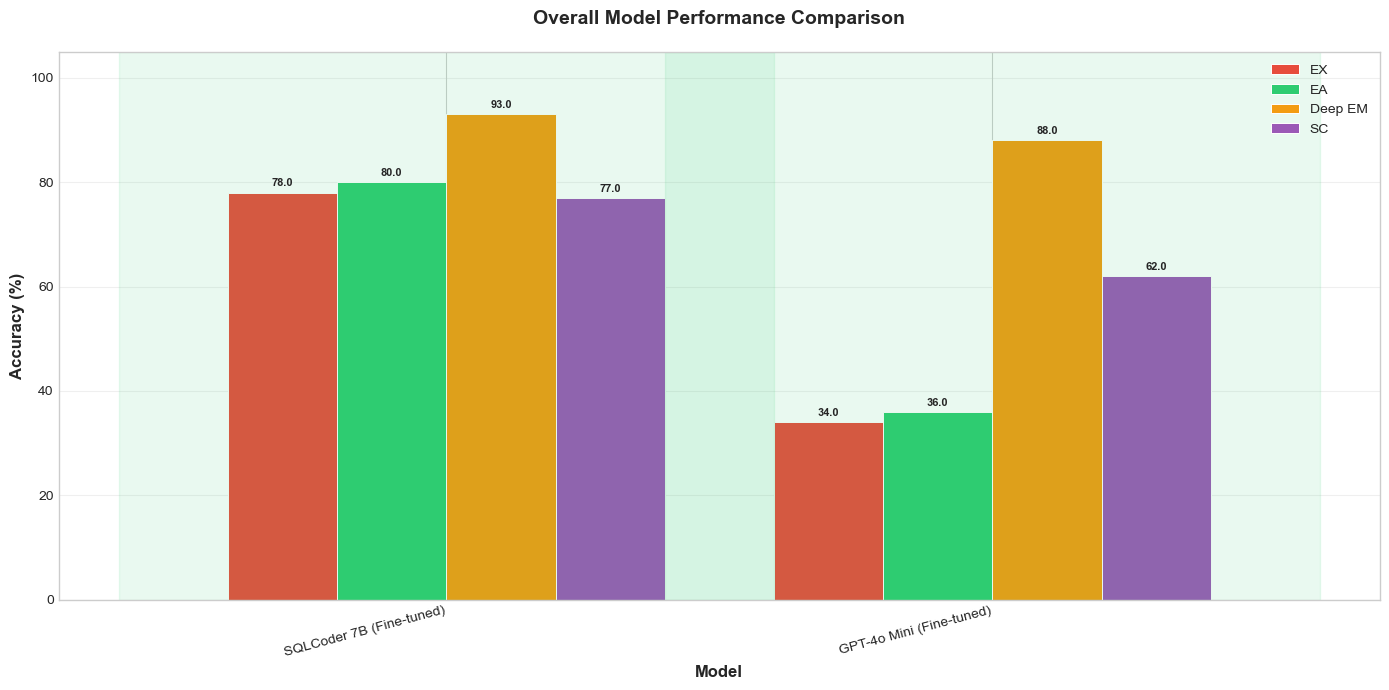

In [5]:
def plot_overall_comparison_bar(df, save_path=None):
    """Grouped bar chart comparing all metrics across models."""
    fig, ax = plt.subplots(figsize=(14, 7))
    
    metrics = ['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']
    colors = ['#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    x = np.arange(len(df))
    width = 0.2
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        bars = ax.bar(x + i * width, df[metric], width, label=metric.replace(' (%)', ''), 
                     color=color, edgecolor='white', linewidth=0.7)
        for bar in bars:
            ax.annotate(f'{bar.get_height():.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                       xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(df['Model'], rotation=15, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3)
    
    # Highlight model types
    for i, row in df.iterrows():
        color = '#2ecc71' if row['Type'] == 'Local' else '#3498db'
        ax.axvspan(i - 0.3, i + 0.9, alpha=0.1, color=color)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight'); print(f'Saved: {save_path}')
    plt.show()

if results:
    Path('figures').mkdir(exist_ok=True)
    plot_overall_comparison_bar(df_overall, 'figures/overall_comparison_bar.png')

## 4. Radar Chart - Multi-Metric Profile

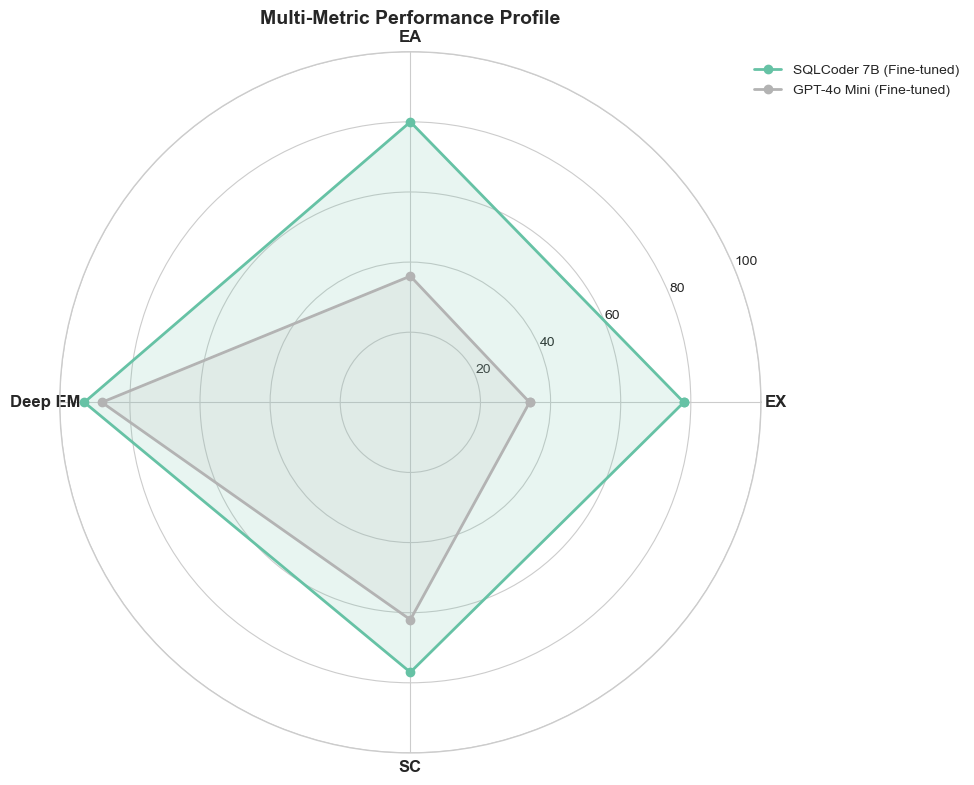

In [6]:
def plot_radar_comparison(df, save_path=None):
    """Radar chart showing multi-metric profile for each model."""
    categories = ['EX', 'EA', 'Deep EM', 'SC']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    colors = plt.cm.Set2(np.linspace(0, 1, len(df)))
    
    for idx, (_, row) in enumerate(df.iterrows()):
        values = [row['EX (%)'], row['EA (%)'], row['Deep EM (%)'], row['SC (%)']]
        values += values[:1]
        linestyle = '-' if row['Type'] == 'Local' else '--'
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx], linestyle=linestyle)
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.set_title('Multi-Metric Performance Profile', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results:
    plot_radar_comparison(df_overall, 'figures/radar_comparison.png')

## 5. Local vs Frontier Models

In [7]:
def plot_local_vs_frontier(df, save_path=None):
    """Side-by-side comparison of best local vs best frontier model."""
    local_df = df[df['Type'] == 'Local']
    frontier_df = df[df['Type'] == 'Frontier']
    
    if local_df.empty or frontier_df.empty:
        print('Need both local and frontier models'); return
    
    best_local = local_df.loc[local_df['EA (%)'].idxmax()]
    best_frontier = frontier_df.loc[frontier_df['EA (%)'].idxmax()]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    metrics = ['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']
    x = np.arange(len(metrics))
    width = 0.35
    
    local_vals = [best_local[m] for m in metrics]
    frontier_vals = [best_frontier[m] for m in metrics]
    
    axes[0].bar(x - width/2, local_vals, width, label=best_local['Model'], color='#2ecc71')
    axes[0].bar(x + width/2, frontier_vals, width, label=best_frontier['Model'], color='#3498db')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Best Local vs Best Frontier', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([m.replace(' (%)', '') for m in metrics])
    axes[0].legend()
    axes[0].set_ylim(0, 105)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Difference chart
    diffs = [l - f for l, f in zip(local_vals, frontier_vals)]
    colors = ['#2ecc71' if d >= 0 else '#e74c3c' for d in diffs]
    bars = axes[1].barh([m.replace(' (%)', '') for m in metrics], diffs, color=colors)
    axes[1].axvline(x=0, color='black', linewidth=0.8)
    axes[1].set_xlabel('Difference (Local - Frontier) %')
    axes[1].set_title('Performance Gap', fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    for bar, diff in zip(bars, diffs):
        axes[1].annotate(f'{diff:+.1f}%', xy=(diff, bar.get_y() + bar.get_height()/2),
                        xytext=(5 if diff >= 0 else -5, 0), textcoords='offset points',
                        ha='left' if diff >= 0 else 'right', va='center', fontweight='bold')
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results:
    plot_local_vs_frontier(df_overall, 'figures/local_vs_frontier.png')

Need both local and frontier models


## 6. Self-Correction Improvement (EX to EA)

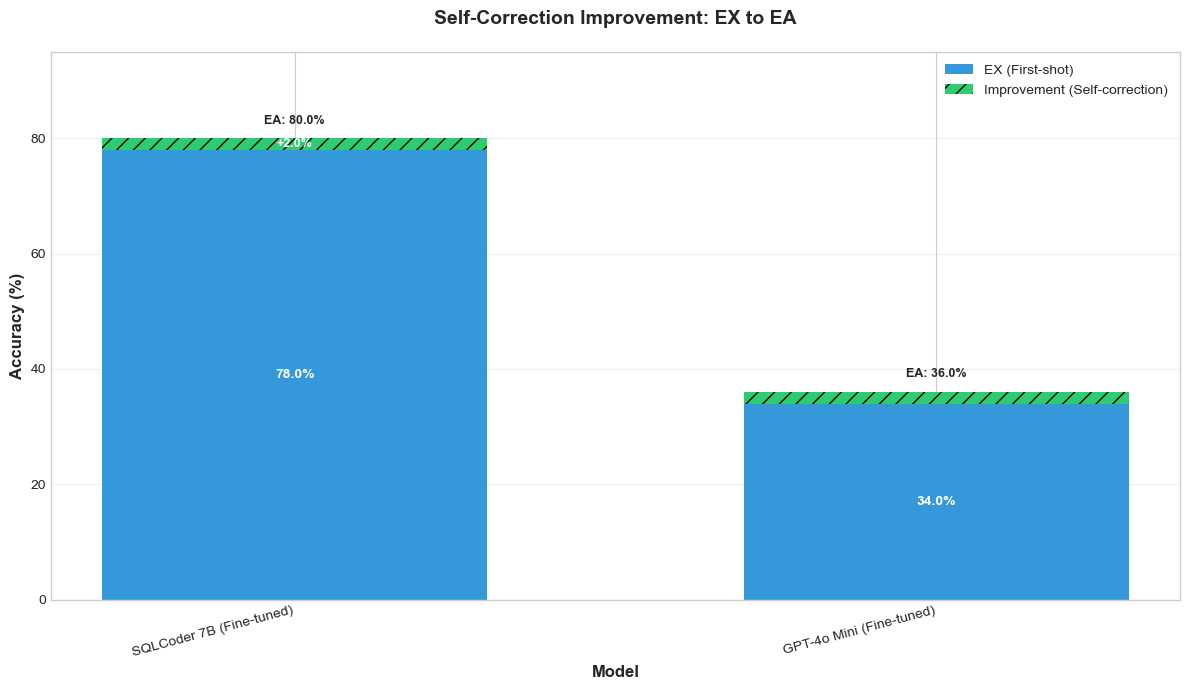

In [8]:
def plot_self_correction(df, save_path=None):
    """Stacked bar showing EX to EA improvement."""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(df))
    width = 0.6
    
    bars1 = ax.bar(x, df['EX (%)'], width, label='EX (First-shot)', color='#3498db')
    bars2 = ax.bar(x, df['Improvement'], width, bottom=df['EX (%)'], 
                   label='Improvement (Self-correction)', color='#2ecc71', hatch='//')
    
    for i, (ex, imp) in enumerate(zip(df['EX (%)'], df['Improvement'])):
        ax.annotate(f'{ex:.1f}%', xy=(i, ex/2), ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        if imp > 2:
            ax.annotate(f'+{imp:.1f}%', xy=(i, ex + imp/2), ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        ax.annotate(f'EA: {ex + imp:.1f}%', xy=(i, ex + imp + 2), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_title('Self-Correction Improvement: EX to EA', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=15, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0, df['EA (%)'].max() + 15)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results:
    plot_self_correction(df_overall, 'figures/self_correction.png')

---
# Part B: Taxonomy-Based Analysis
---

## 7. Performance by Task Type (Heatmap)

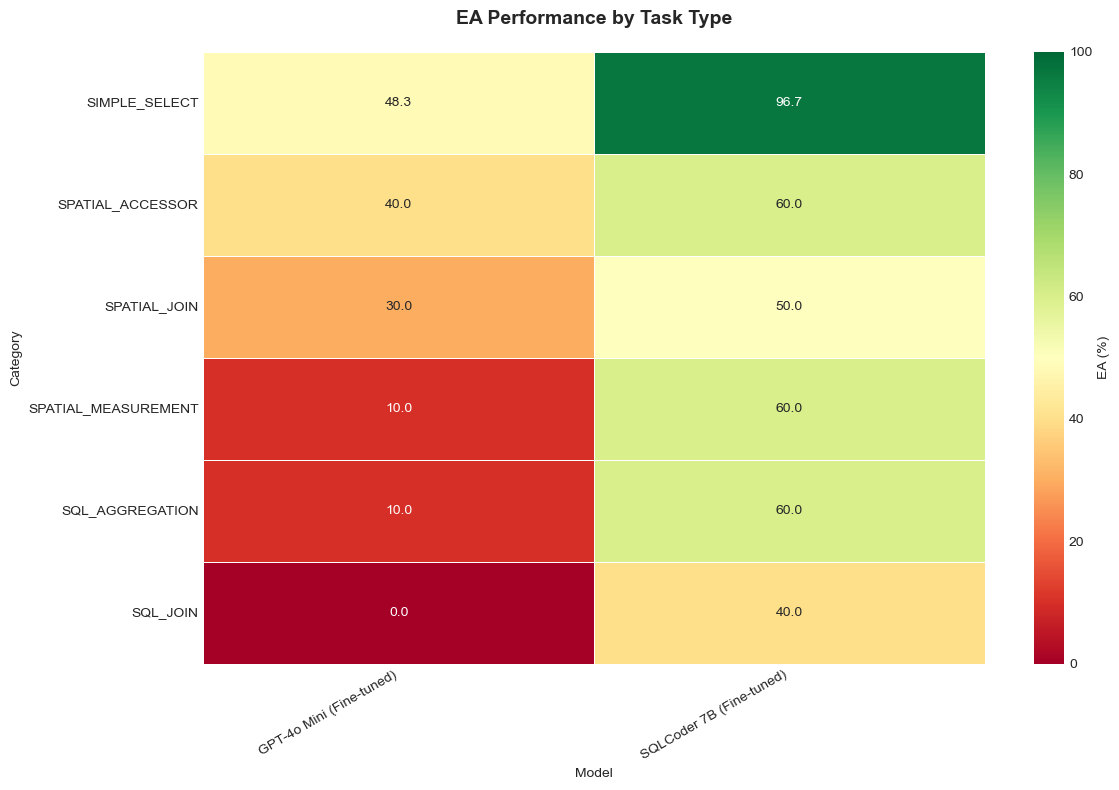

In [9]:
def plot_taxonomy_heatmap(df, metric='EA (%)', title='Performance by Category', save_path=None):
    """Heatmap showing performance across taxonomy categories."""
    if df.empty: print('No data'); return
    
    pivot = df.pivot_table(index='Category', columns='Model', values=metric, aggfunc='mean')
    pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(pivot) * 0.5)))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', linewidths=0.5, ax=ax, vmin=0, vmax=100,
                cbar_kws={'label': metric})
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results and not df_task_type.empty:
    plot_taxonomy_heatmap(df_task_type, 'EA (%)', 'EA Performance by Task Type', 'figures/heatmap_task_type.png')

## 8. Performance by Task Complexity

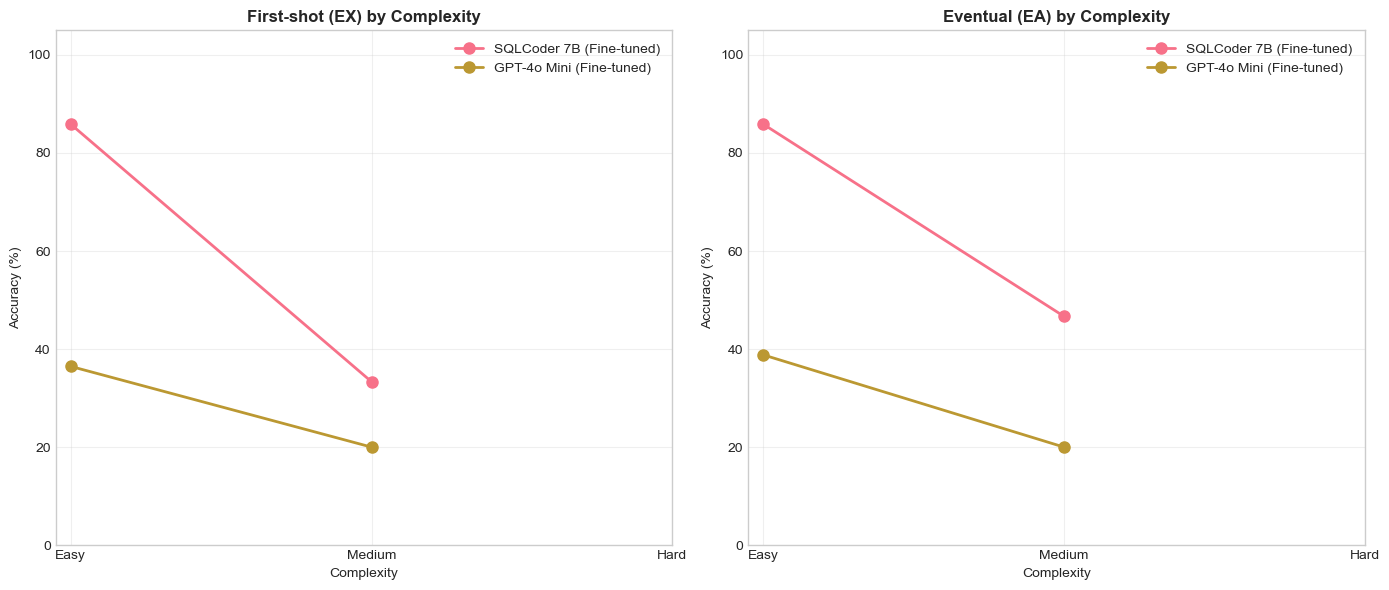

In [10]:
def plot_complexity_comparison(df, save_path=None):
    """Line chart showing performance vs complexity."""
    if df.empty: print('No data'); return
    
    df = df.copy()
    df['Level'] = df['Category'].apply(lambda x: int(x.split('_')[0]) if x[0].isdigit() else 0)
    df = df[df['Level'] > 0]
    if df.empty: print('No complexity levels'); return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for model in df['Model'].unique():
        m_df = df[df['Model'] == model].sort_values('Level')
        ls = '-' if m_df['Type'].iloc[0] == 'Local' else '--'
        axes[0].plot(m_df['Level'], m_df['EX (%)'], 'o-', label=model, linewidth=2, markersize=8, linestyle=ls)
        axes[1].plot(m_df['Level'], m_df['EA (%)'], 'o-', label=model, linewidth=2, markersize=8, linestyle=ls)
    
    for ax, title in zip(axes, ['First-shot (EX) by Complexity', 'Eventual (EA) by Complexity']):
        ax.set_xlabel('Complexity')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(title, fontweight='bold')
        ax.set_xticks([1, 2, 3])
        ax.set_xticklabels(['Easy', 'Medium', 'Hard'])
        ax.legend(loc='best')
        ax.grid(alpha=0.3)
        ax.set_ylim(0, 105)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results and not df_task_complexity.empty:
    plot_complexity_comparison(df_task_complexity, 'figures/complexity_comparison.png')

## 9. Question Tone Analysis (5 categories)

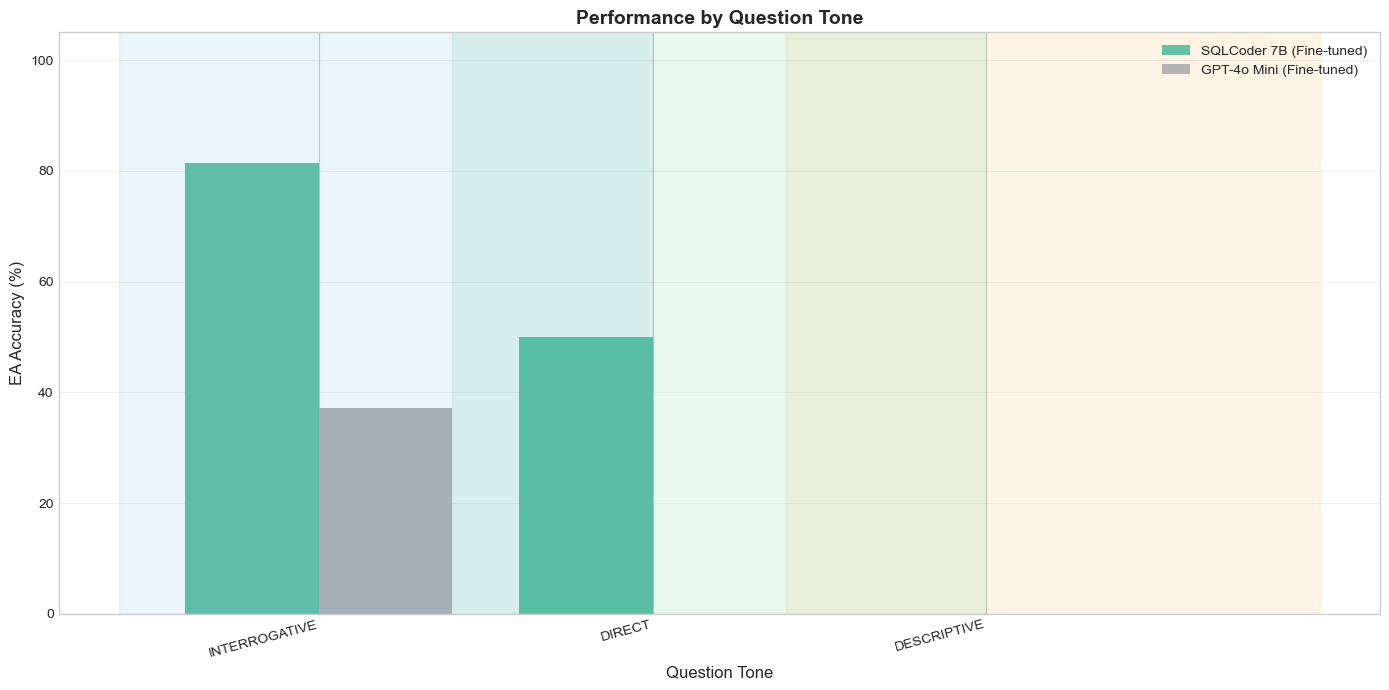

In [11]:
def plot_question_tone(df, save_path=None):
    """Bar chart for question tone performance (INTERROGATIVE, DIRECT, DESCRIPTIVE, AMBIGUOUS, OUT_OF_SCOPE)."""
    if df.empty: print('No data'); return
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    models = df['Model'].unique()
    tones = df['Category'].unique()
    x = np.arange(len(tones))
    width = 0.8 / len(models)
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        m_df = df[df['Model'] == model]
        vals = [m_df[m_df['Category'] == t]['EA (%)'].values[0] if len(m_df[m_df['Category'] == t]) > 0 else 0 for t in tones]
        ax.bar(x + i * width, vals, width, label=model, color=colors[i])
    
    ax.set_xlabel('Question Tone', fontsize=12)
    ax.set_ylabel('EA Accuracy (%)', fontsize=12)
    ax.set_title('Performance by Question Tone', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(tones, rotation=15, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3)
    
    # Add tone color indicators
    for i, tone in enumerate(tones):
        color = TONE_COLORS.get(tone, '#95a5a6')
        ax.axvspan(i - 0.4, i + 0.4 + width * len(models), alpha=0.1, color=color)
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results and not df_question_tone.empty:
    plot_question_tone(df_question_tone, 'figures/question_tone.png')

## 10. Sample Dirtiness Analysis (CLEAN, AMBIGUOUS, OUT_OF_SCOPE)

In [12]:
def plot_sample_dirtiness(df, save_path=None):
    """Compare performance on clean vs negative samples."""
    if df.empty: print('No data'); return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    models = df['Model'].unique()
    categories = df['Category'].unique()
    x = np.arange(len(categories))
    width = 0.8 / len(models)
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        m_df = df[df['Model'] == model]
        vals = [m_df[m_df['Category'] == c]['EA (%)'].values[0] if len(m_df[m_df['Category'] == c]) > 0 else 0 for c in categories]
        axes[0].bar(x + i * width, vals, width, label=model, color=colors[i])
    
    axes[0].set_xlabel('Sample Type')
    axes[0].set_ylabel('EA Accuracy (%)')
    axes[0].set_title('Performance by Sample Dirtiness', fontweight='bold')
    axes[0].set_xticks(x + width * (len(models) - 1) / 2)
    axes[0].set_xticklabels(categories)
    axes[0].legend(loc='upper right')
    axes[0].set_ylim(0, 105)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Clean vs Negative gap
    if 'CLEAN' in categories:
        gaps = []
        for model in models:
            m_df = df[df['Model'] == model]
            clean = m_df[m_df['Category'] == 'CLEAN']['EA (%)'].values
            clean = clean[0] if len(clean) > 0 else 0
            neg = m_df[m_df['Category'] != 'CLEAN']['EA (%)'].values
            neg_avg = np.mean(neg) if len(neg) > 0 else 0
            gaps.append(clean - neg_avg)
        
        gap_colors = ['#2ecc71' if g >= 0 else '#e74c3c' for g in gaps]
        bars = axes[1].barh(models, gaps, color=gap_colors)
        axes[1].axvline(x=0, color='black', linewidth=0.8)
        axes[1].set_xlabel('Gap (Clean - Negative) %')
        axes[1].set_title('Clean vs Negative Gap', fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
        
        for bar, gap in zip(bars, gaps):
            axes[1].annotate(f'{gap:+.1f}%', xy=(gap, bar.get_y() + bar.get_height()/2),
                            xytext=(5 if gap >= 0 else -5, 0), textcoords='offset points',
                            ha='left' if gap >= 0 else 'right', va='center', fontweight='bold')
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if results and not df_sample_dirtiness.empty:
    plot_sample_dirtiness(df_sample_dirtiness, 'figures/sample_dirtiness.png')

---
# Part C: Interactive Plotly Visualizations
---

## 11. Interactive Overall Comparison

In [13]:
def plot_interactive_overall(df):
    """Interactive Plotly bar chart."""
    fig = go.Figure()
    metrics = [('EX (%)', '#e74c3c'), ('EA (%)', '#2ecc71'), ('Deep EM (%)', '#f39c12'), ('SC (%)', '#9b59b6')]
    
    for metric, color in metrics:
        fig.add_trace(go.Bar(name=metric.replace(' (%)', ''), x=df['Model'], y=df[metric],
                            marker_color=color, text=df[metric].round(1), textposition='auto'))
    
    fig.update_layout(title='<b>Model Performance Comparison</b>', xaxis_title='Model', yaxis_title='Accuracy (%)',
                     barmode='group', template='plotly_white', height=500,
                     legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1))
    fig.show()
    return fig

if results:
    fig_interactive = plot_interactive_overall(df_overall)

## 12. Interactive Radar Chart

In [14]:
def plot_interactive_radar(df):
    """Interactive Plotly radar chart."""
    categories = ['EX', 'EA', 'Deep EM', 'SC']
    fig = go.Figure()
    colors = px.colors.qualitative.Set2
    
    for idx, (_, row) in enumerate(df.iterrows()):
        values = [row['EX (%)'], row['EA (%)'], row['Deep EM (%)'], row['SC (%)']]
        values.append(values[0])
        fig.add_trace(go.Scatterpolar(r=values, theta=categories + [categories[0]], fill='toself',
                                      name=row['Model'], line=dict(color=colors[idx % len(colors)]), opacity=0.7))
    
    fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
                     title='<b>Multi-Metric Profile</b>', template='plotly_white', height=600)
    fig.show()
    return fig

if results:
    fig_radar = plot_interactive_radar(df_overall)

## 13. Interactive Heatmap

In [15]:
def plot_interactive_heatmap(df, metric='EA (%)'):
    """Interactive Plotly heatmap."""
    if df.empty: print('No data'); return None
    
    pivot = df.pivot_table(index='Category', columns='Model', values=metric, aggfunc='mean')
    pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]
    
    fig = go.Figure(data=go.Heatmap(z=pivot.values, x=pivot.columns, y=pivot.index,
                                    colorscale='RdYlGn', zmin=0, zmax=100,
                                    text=np.round(pivot.values, 1), texttemplate='%{text}', textfont={'size': 10}))
    fig.update_layout(title=f'<b>{metric} by Task Type</b>', template='plotly_white', height=max(400, len(pivot) * 30))
    fig.show()
    return fig

if results and not df_task_type.empty:
    fig_heatmap = plot_interactive_heatmap(df_task_type, 'EA (%)')

## 14. Parallel Coordinates Plot

In [16]:
def plot_parallel_coordinates(df):
    """Parallel coordinates for multi-dimensional comparison."""
    df_plot = df.copy()
    df_plot['Type_num'] = df_plot['Type'].map({'Local': 0, 'Frontier': 1})
    
    fig = go.Figure(data=go.Parcoords(
        line=dict(color=df_plot['Type_num'], colorscale=[[0, '#2ecc71'], [1, '#3498db']], showscale=True,
                 colorbar=dict(title='Type', tickvals=[0, 1], ticktext=['Local', 'Frontier'])),
        dimensions=[
            dict(label='EX (%)', values=df_plot['EX (%)'], range=[0, 100]),
            dict(label='EA (%)', values=df_plot['EA (%)'], range=[0, 100]),
            dict(label='Deep EM (%)', values=df_plot['Deep EM (%)'], range=[0, 100]),
            dict(label='SC (%)', values=df_plot['SC (%)'], range=[0, 100]),
            dict(label='Improvement', values=df_plot['Improvement'], range=[-10, 30]),
            dict(label='Avg Iterations', values=df_plot['Avg Iterations'], range=[1, 5])
        ]
    ))
    fig.update_layout(title='<b>Multi-Dimensional Comparison</b>', template='plotly_white', height=500)
    fig.show()
    return fig

if results:
    fig_parallel = plot_parallel_coordinates(df_overall)

---
# Part D: Publication-Ready Figures
---

## 15. Combined 4-Panel Summary Figure

Saved: figures/publication_summary.png


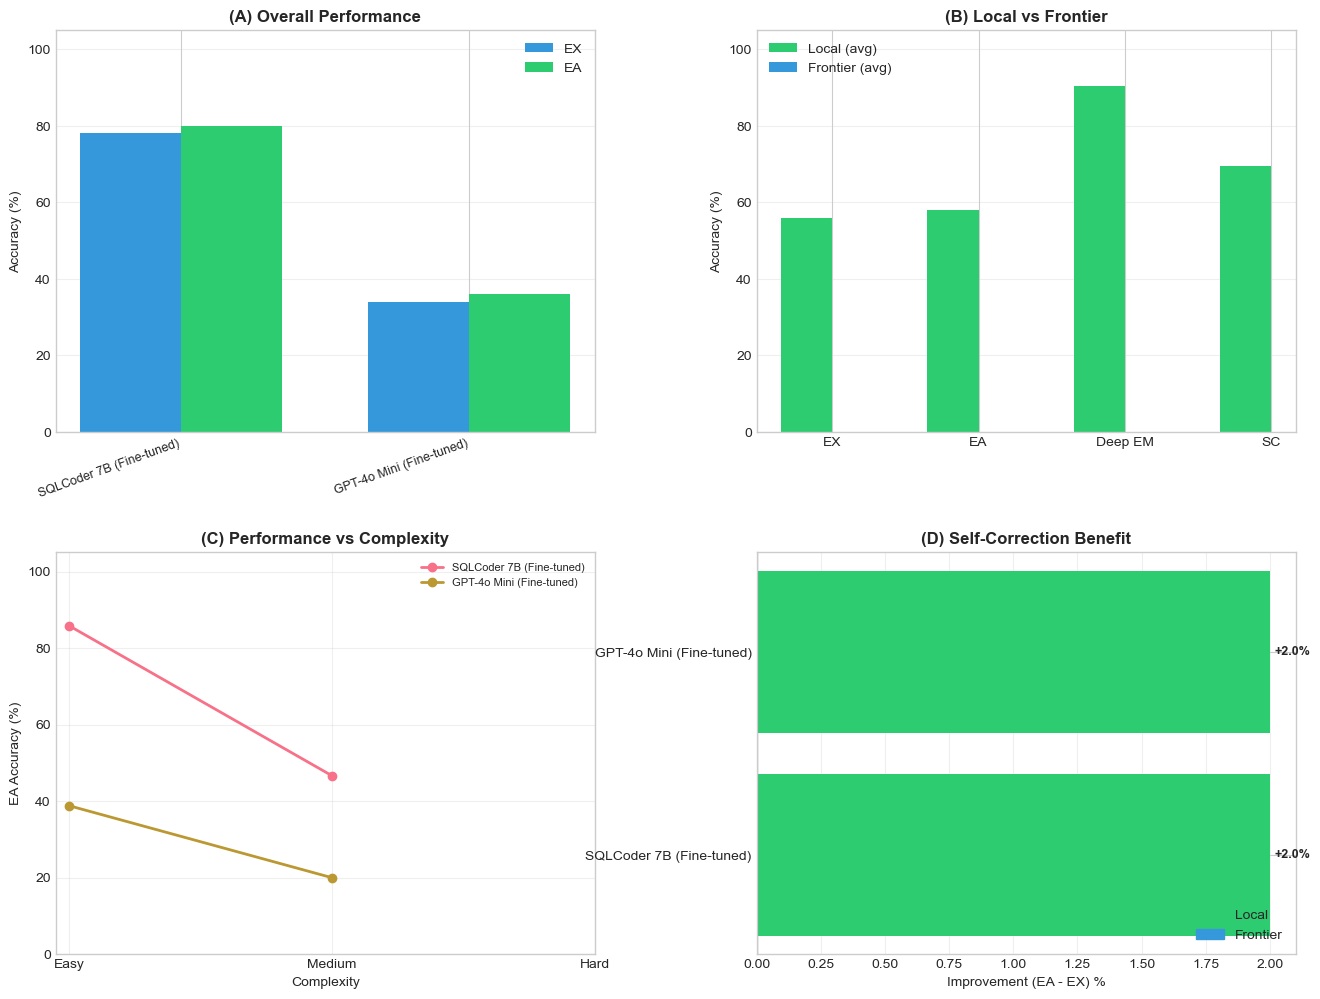

In [17]:
def create_publication_figure(df_overall, df_complexity, save_path=None):
    """4-panel publication-ready summary figure."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
    
    # Panel A: Overall comparison
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(df_overall))
    width = 0.35
    ax1.bar(x - width/2, df_overall['EX (%)'], width, label='EX', color='#3498db')
    ax1.bar(x + width/2, df_overall['EA (%)'], width, label='EA', color='#2ecc71')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('(A) Overall Performance', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_overall['Model'], rotation=20, ha='right', fontsize=9)
    ax1.legend()
    ax1.set_ylim(0, 105)
    ax1.grid(axis='y', alpha=0.3)
    
    # Panel B: Local vs Frontier averages
    ax2 = fig.add_subplot(gs[0, 1])
    local_avg = df_overall[df_overall['Type'] == 'Local'][['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']].mean()
    frontier_avg = df_overall[df_overall['Type'] == 'Frontier'][['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']].mean()
    if not local_avg.empty and not frontier_avg.empty:
        metrics = ['EX', 'EA', 'Deep EM', 'SC']
        x2 = np.arange(len(metrics))
        ax2.bar(x2 - width/2, local_avg.values, width, label='Local (avg)', color='#2ecc71')
        ax2.bar(x2 + width/2, frontier_avg.values, width, label='Frontier (avg)', color='#3498db')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('(B) Local vs Frontier', fontweight='bold')
        ax2.set_xticks(x2)
        ax2.set_xticklabels(metrics)
        ax2.legend()
        ax2.set_ylim(0, 105)
        ax2.grid(axis='y', alpha=0.3)
    
    # Panel C: Complexity degradation
    ax3 = fig.add_subplot(gs[1, 0])
    if not df_complexity.empty:
        df_c = df_complexity.copy()
        df_c['Level'] = df_c['Category'].apply(lambda x: int(x.split('_')[0]) if x[0].isdigit() else 0)
        df_c = df_c[df_c['Level'] > 0]
        for model in df_c['Model'].unique():
            m_df = df_c[df_c['Model'] == model].sort_values('Level')
            ls = '-' if m_df['Type'].iloc[0] == 'Local' else '--'
            ax3.plot(m_df['Level'], m_df['EA (%)'], 'o-', label=model, linewidth=2, markersize=6, linestyle=ls)
        ax3.set_xlabel('Complexity')
        ax3.set_ylabel('EA Accuracy (%)')
        ax3.set_title('(C) Performance vs Complexity', fontweight='bold')
        ax3.set_xticks([1, 2, 3])
        ax3.set_xticklabels(['Easy', 'Medium', 'Hard'])
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)
        ax3.set_ylim(0, 105)
    
    # Panel D: Self-correction benefit
    ax4 = fig.add_subplot(gs[1, 1])
    colors = ['#2ecc71' if t == 'Local' else '#3498db' for t in df_overall['Type']]
    bars = ax4.barh(df_overall['Model'], df_overall['Improvement'], color=colors)
    ax4.axvline(x=0, color='black', linewidth=0.8)
    ax4.set_xlabel('Improvement (EA - EX) %')
    ax4.set_title('(D) Self-Correction Benefit', fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    for bar, imp in zip(bars, df_overall['Improvement']):
        ax4.annotate(f'{imp:+.1f}%', xy=(imp, bar.get_y() + bar.get_height()/2),
                    xytext=(3 if imp >= 0 else -3, 0), textcoords='offset points',
                    ha='left' if imp >= 0 else 'right', va='center', fontsize=9, fontweight='bold')
    ax4.legend(handles=[mpatches.Patch(color='#2ecc71', label='Local'), mpatches.Patch(color='#3498db', label='Frontier')], loc='lower right')
    
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight'); print(f'Saved: {save_path}')
    plt.show()

if results:
    create_publication_figure(df_overall, df_task_complexity, 'figures/publication_summary.png')

## 16. Model Characteristics Table

In [18]:
def create_characteristics_table(results):
    """Create model characteristics summary table."""
    rows = []
    for r in results:
        task_metrics = r.taxonomy.get('by_task_type', {})
        best_task = max(task_metrics.items(), key=lambda x: x[1].get('ea_rate', 0))[0] if task_metrics else 'N/A'
        worst_task = min(task_metrics.items(), key=lambda x: x[1].get('ea_rate', 1))[0] if task_metrics else 'N/A'
        rows.append({
            'Model': r.display_name, 'Type': r.model_type.capitalize(), 'Params': r.parameters or 'API',
            'EX': f"{r.get_metric('ex')*100:.1f}%", 'EA': f"{r.get_metric('ea')*100:.1f}%",
            'Deep EM': f"{r.get_metric('deep_em')*100:.1f}%", 'SC': f"{r.get_metric('sc')*100:.1f}%",
            'Avg Iter': f"{r.overall.get('average_iterations', 0):.2f}",
            'Self-Corr': f"{r.overall.get('self_correction_rate', 0)*100:.1f}%",
            'Best Task': best_task, 'Worst Task': worst_task
        })
    return pd.DataFrame(rows)

if results:
    df_chars = create_characteristics_table(results)
    print('Model Characteristics:')
    display(df_chars)

Model Characteristics:


,Model,Type,Params,EX,EA,Deep EM,SC,Avg Iter,Self-Corr,Best Task,Worst Task
0,SQLCoder 7B (Fine-tuned),Local,7B,78.0%,80.0%,93.0%,77.0%,1.19,9.1%,SIMPLE_SELECT,SQL_JOIN
1,GPT-4o Mini (Fine-tuned),Local,API,34.0%,36.0%,88.0%,62.0%,1.81,3.0%,SIMPLE_SELECT,SQL_JOIN


## 17. Export LaTeX Tables

In [19]:
def export_latex(df, filename, caption, label):
    """Export DataFrame as LaTeX table."""
    Path('tables').mkdir(exist_ok=True)
    latex = df.to_latex(index=False, caption=caption, label=label, column_format='l' + 'c' * (len(df.columns) - 1))
    with open(f'tables/{filename}', 'w') as f: f.write(latex)
    print(f'Saved: tables/{filename}')
    return latex

if results:
    latex = export_latex(df_overall[['Model', 'Type', 'EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']],
                        'overall_results.tex', 'Overall Model Performance', 'tab:overall')
    print('\nLaTeX Preview:')
    print(latex)

Saved: tables/overall_results.tex

LaTeX Preview:
\begin{table}
\caption{Overall Model Performance}
\label{tab:overall}
\begin{tabular}{lccccc}
\toprule
Model & Type & EX (%) & EA (%) & Deep EM (%) & SC (%) \\
\midrule
SQLCoder 7B (Fine-tuned) & Local & 78.000000 & 80.000000 & 93.000000 & 77.000000 \\
GPT-4o Mini (Fine-tuned) & Local & 34.000000 & 36.000000 & 88.000000 & 62.000000 \\
\bottomrule
\end{tabular}
\end{table}



---
# Part E: Statistical Analysis & Key Findings
---

## 18. Statistical Summary

In [20]:
def compute_stats(df):
    """Compute statistical summary."""
    summary = {}
    for metric in ['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']:
        summary[metric] = {'mean': df[metric].mean(), 'std': df[metric].std(),
                          'min': df[metric].min(), 'max': df[metric].max(),
                          'best': df.loc[df[metric].idxmax(), 'Model']}
    
    local_df = df[df['Type'] == 'Local']
    frontier_df = df[df['Type'] == 'Frontier']
    if not local_df.empty and not frontier_df.empty:
        summary['local_vs_frontier'] = {
            'local_ea': local_df['EA (%)'].mean(),
            'frontier_ea': frontier_df['EA (%)'].mean(),
            'gap': local_df['EA (%)'].mean() - frontier_df['EA (%)'].mean()
        }
    
    summary['self_correction'] = {
        'avg_improvement': df['Improvement'].mean(),
        'max_improvement': df['Improvement'].max(),
        'best_improver': df.loc[df['Improvement'].idxmax(), 'Model']
    }
    return summary

if results:
    stats = compute_stats(df_overall)
    print('=' * 60)
    print('STATISTICAL SUMMARY')
    print('=' * 60)
    for metric in ['EX (%)', 'EA (%)', 'Deep EM (%)', 'SC (%)']:
        s = stats[metric]
        print(f"\n{metric}: Mean={s['mean']:.1f}%, Std={s['std']:.1f}%, Range=[{s['min']:.1f}%, {s['max']:.1f}%], Best={s['best']}")
    if 'local_vs_frontier' in stats:
        lvf = stats['local_vs_frontier']
        print(f"\nLocal vs Frontier: Local={lvf['local_ea']:.1f}%, Frontier={lvf['frontier_ea']:.1f}%, Gap={lvf['gap']:+.1f}%")
    sc = stats['self_correction']
    print(f"\nSelf-Correction: Avg={sc['avg_improvement']:.1f}%, Max={sc['max_improvement']:.1f}% ({sc['best_improver']})")

STATISTICAL SUMMARY

EX (%): Mean=56.0%, Std=31.1%, Range=[34.0%, 78.0%], Best=SQLCoder 7B (Fine-tuned)

EA (%): Mean=58.0%, Std=31.1%, Range=[36.0%, 80.0%], Best=SQLCoder 7B (Fine-tuned)

Deep EM (%): Mean=90.5%, Std=3.5%, Range=[88.0%, 93.0%], Best=SQLCoder 7B (Fine-tuned)

SC (%): Mean=69.5%, Std=10.6%, Range=[62.0%, 77.0%], Best=SQLCoder 7B (Fine-tuned)

Self-Correction: Avg=2.0%, Max=2.0% (SQLCoder 7B (Fine-tuned))


## 19. Key Findings

In [21]:
def generate_findings(df, results):
    """Generate key findings summary."""
    findings = []
    
    best_ea = df.loc[df['EA (%)'].idxmax()]
    findings.append(f"1. **Best Overall**: {best_ea['Model']} achieved EA of {best_ea['EA (%)']:.1f}%")
    
    local_df = df[df['Type'] == 'Local']
    frontier_df = df[df['Type'] == 'Frontier']
    if not local_df.empty and not frontier_df.empty:
        best_local = local_df.loc[local_df['EA (%)'].idxmax()]
        best_frontier = frontier_df.loc[frontier_df['EA (%)'].idxmax()]
        if best_local['EA (%)'] >= best_frontier['EA (%)']:
            findings.append(f"2. **Local Competitive**: {best_local['Model']} ({best_local['EA (%)']:.1f}%) >= {best_frontier['Model']} ({best_frontier['EA (%)']:.1f}%)")
        else:
            gap = best_frontier['EA (%)'] - best_local['EA (%)']
            findings.append(f"2. **Frontier Lead**: {best_frontier['Model']} leads by {gap:.1f}%")
    
    findings.append(f"3. **Self-Correction**: Average improvement of {df['Improvement'].mean():.1f}% (EX to EA)")
    
    best_imp = df.loc[df['Improvement'].idxmax()]
    findings.append(f"4. **Best Self-Corrector**: {best_imp['Model']} improved by {best_imp['Improvement']:.1f}%")
    
    corr = df['EA (%)'].corr(df['Deep EM (%)'])
    findings.append(f"5. **EA-DeepEM Correlation**: {corr:.2f}")
    
    return '\n\n'.join(findings)

if results:
    print('=' * 60)
    print('KEY FINDINGS')
    print('=' * 60)
    print()
    print(generate_findings(df_overall, results))

KEY FINDINGS

1. **Best Overall**: SQLCoder 7B (Fine-tuned) achieved EA of 80.0%

3. **Self-Correction**: Average improvement of 2.0% (EX to EA)

4. **Best Self-Corrector**: SQLCoder 7B (Fine-tuned) improved by 2.0%

5. **EA-DeepEM Correlation**: 1.00


---
## Summary

### Static Figures (Matplotlib):
1. Overall bar chart
2. Radar chart
3. Local vs Frontier
4. Self-correction waterfall
5. Task type heatmap
6. Complexity lines
7. Question tone (5 categories)
8. Sample dirtiness (3 categories)
9. Publication 4-panel

### Interactive (Plotly):
10. Interactive bar
11. Interactive radar
12. Interactive heatmap
13. Parallel coordinates

### Analysis:
14. Characteristics table
15. LaTeX export
16. Statistical summary
17. Key findings